In [1]:
import torch
import matplotlib.pyplot as plt

## Data

In [2]:
LOW_RADIUS = 1.
HIGH_RADIUS = 2.
NUM_SAMPLES = 1000

In [3]:
theta_0 = torch.rand(NUM_SAMPLES, 1) * 2 * torch.pi
theta_1 = torch.rand(NUM_SAMPLES, 1) * 2 * torch.pi

In [4]:
X1_0 = torch.cos(theta_0) * LOW_RADIUS
X2_0 = torch.sin(theta_0) * LOW_RADIUS
Y_0 = torch.zeros(len(X1_0), 1)
X1_1 = torch.cos(theta_1) * HIGH_RADIUS
X2_1 = torch.sin(theta_1) * HIGH_RADIUS
Y_1 = torch.ones(len(X1_1), 1)

In [5]:
X = torch.cat([
    torch.cat([X1_0, X2_0], dim=1),
    torch.cat([X1_1, X2_1], dim=1)
], dim=0)
Y = torch.cat([Y_0, Y_1], dim=0)
X.shape, Y.shape

(torch.Size([2000, 2]), torch.Size([2000, 1]))

In [6]:
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.25)
X_train.shape, X_test.shape, Y_train.shape, Y_test.shape

(torch.Size([1500, 2]),
 torch.Size([500, 2]),
 torch.Size([1500, 1]),
 torch.Size([500, 1]))

## Model

In [7]:
device = 'cpu'

In [8]:
from torch import nn

class SimpleNN(nn.Module):
    def __init__(self) -> None:
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(in_features=2, out_features=32),
            nn.ReLU(),
            nn.Linear(in_features=32, out_features=32),
            nn.ReLU(),
            nn.Linear(in_features=32, out_features=1),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        return self.layers(x)

In [9]:
from scripts.metrics import BinaryAccuracy

model = SimpleNN().to(device)
loss_fn = torch.nn.BCELoss()
optimizer = torch.optim.Adam(params=model.parameters(), lr=1e-4)
metric = BinaryAccuracy()

In [10]:
epochs = 100

In [11]:
from scripts.utils import make_dataloader

train_dataloader = make_dataloader(X_train, Y_train, batch_size=32, shuffle=True)

In [12]:
XLIM = (-2.5, 2.5)
YLIM = (-2.5, 2.5)
XSTEP = 100
YSTEP = 100

In [13]:
from typing import Tuple
from scripts.test import predict

def get_decision_surface(
    model: torch.nn.Module,
    xlim: Tuple[float, float] = XLIM,
    ylim: Tuple[float, float] = XLIM,
    xstep: float = XSTEP,
    ystep: float = YSTEP
) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
    x_range = torch.linspace(xlim[0], xlim[1], xstep)
    y_range = torch.linspace(ylim[0], ylim[1], ystep)
    X_grid, Y_grid = torch.meshgrid(x_range, y_range, indexing='xy')
    X_all, Y_all = X_grid.reshape(-1, 1), Y_grid.reshape(-1, 1)
    input_all = torch.cat([X_all, Y_all], dim=1)
    output_all = torch.round(predict(model=model, x=input_all, device=device))
    Z_grid = torch.reshape(output_all, X_grid.shape)

    return X_grid, Y_grid, Z_grid

In [14]:
from matplotlib.animation import FuncAnimation, PillowWriter

In [15]:
history = {
    'epochs': [],
    'train_loss': [],
    'train_score': [],
    'models': []
}

for epoch in range(epochs):
    train_loss, train_score = 0., 0.
    for (X, y) in train_dataloader:
        X, y = X.to(device), y.to(device)

        model.train()
        preds = model(X)
        loss = loss_fn(preds, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss
        train_score += metric(preds, y)

    train_loss /= len(train_dataloader)
    train_score /= len(train_dataloader)
    history['epochs'].append(epoch+1)
    history['train_loss'].append(train_loss.detach().cpu().numpy())
    history['train_score'].append(train_score.detach().cpu().numpy())
    curr_model = SimpleNN().to(device)
    curr_model.load_state_dict(model.state_dict())
    history['models'].append(curr_model)
    print(f'Epoch {epoch+1} => Train loss: {train_loss:.6f}, Train score: {train_score:.6f}')


Epoch 1 => Train loss: 0.678342, Train score: 0.514533
Epoch 2 => Train loss: 0.671043, Train score: 0.561075
Epoch 3 => Train loss: 0.664402, Train score: 0.567249
Epoch 4 => Train loss: 0.657454, Train score: 0.553191
Epoch 5 => Train loss: 0.650225, Train score: 0.521467
Epoch 6 => Train loss: 0.642720, Train score: 0.496771
Epoch 7 => Train loss: 0.634679, Train score: 0.496865
Epoch 8 => Train loss: 0.625579, Train score: 0.496960
Epoch 9 => Train loss: 0.615844, Train score: 0.496581
Epoch 10 => Train loss: 0.604571, Train score: 0.496865
Epoch 11 => Train loss: 0.592293, Train score: 0.496581
Epoch 12 => Train loss: 0.580120, Train score: 0.496581
Epoch 13 => Train loss: 0.568072, Train score: 0.496676
Epoch 14 => Train loss: 0.555828, Train score: 0.509593
Epoch 15 => Train loss: 0.543367, Train score: 0.582067
Epoch 16 => Train loss: 0.530309, Train score: 0.693199
Epoch 17 => Train loss: 0.516364, Train score: 0.835486
Epoch 18 => Train loss: 0.502095, Train score: 0.894757
E

Text(0.5, 1.0, 'Training score')

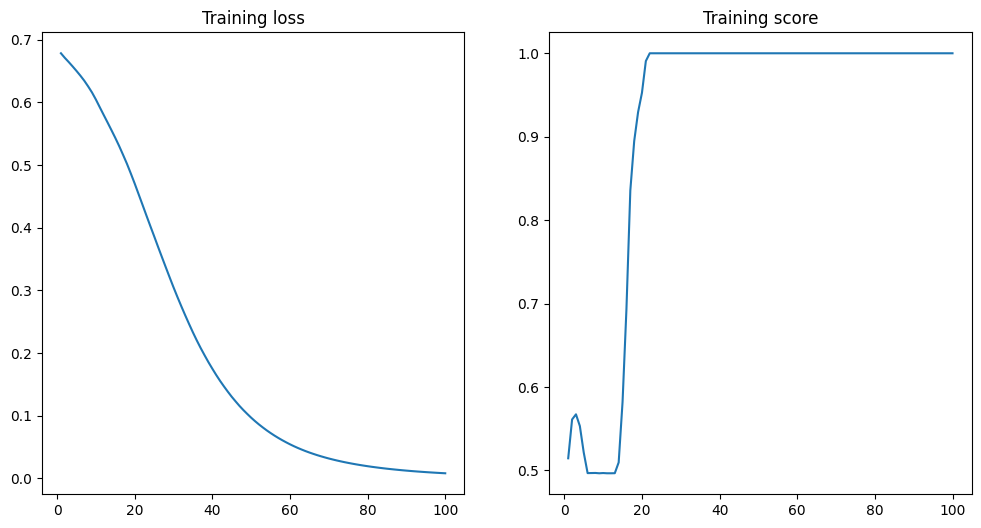

In [16]:
plt.figure(figsize=(12, 6))

plt.subplot(121)
plt.plot(history['epochs'], history['train_loss'])
plt.title('Training loss')

plt.subplot(122)
plt.plot(history['epochs'], history['train_score'])
plt.title('Training score')

In [17]:
from scripts.test import predict

preds_train, preds_test = predict(model=model, x=X_train, device=device), predict(model=model, x=X_test, device=device)
score_train, score_test = metric(preds_train, Y_train), metric(preds_test, Y_test)
score_train, score_test

(tensor(1.), tensor(1.))

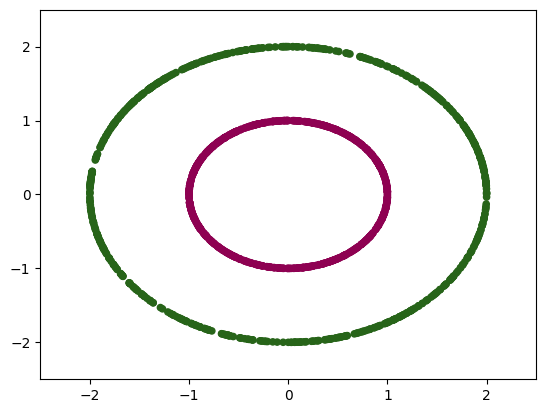

In [19]:
import numpy as np

fig, ax = plt.subplots()
ax.set_xlim(XLIM)
ax.set_ylim(YLIM)
ax.scatter(X_train[:, 0], X_train[:, 1], s=20, c=Y_train, cmap='PiYG')

def animate(i):
    model = history['models'][i]
    X_grid, Y_grid, Z_grid = get_decision_surface(model)
    ax.clear()
    ax.scatter(X_train[:, 0], X_train[:, 1], s=20, c=Y_train, cmap='PiYG')
    sc = ax.scatter(X_grid, Y_grid, s=8, c=Z_grid, cmap='PiYG', alpha=0.25)
    ax.set_title('Epoch ' + str(i+1))
    fig.tight_layout()
    return sc

def init_animate():
    return animate(0)

ani = FuncAnimation(fig=fig, func=animate, frames=range(epochs), interval=50, repeat=True)
plt.show()
writer = PillowWriter(fps=20, metadata=dict(artist='Me'), bitrate=1800)

ani.save('animations/2DCirclesTrain.gif', writer=writer)